Backtest Result: 7483.17


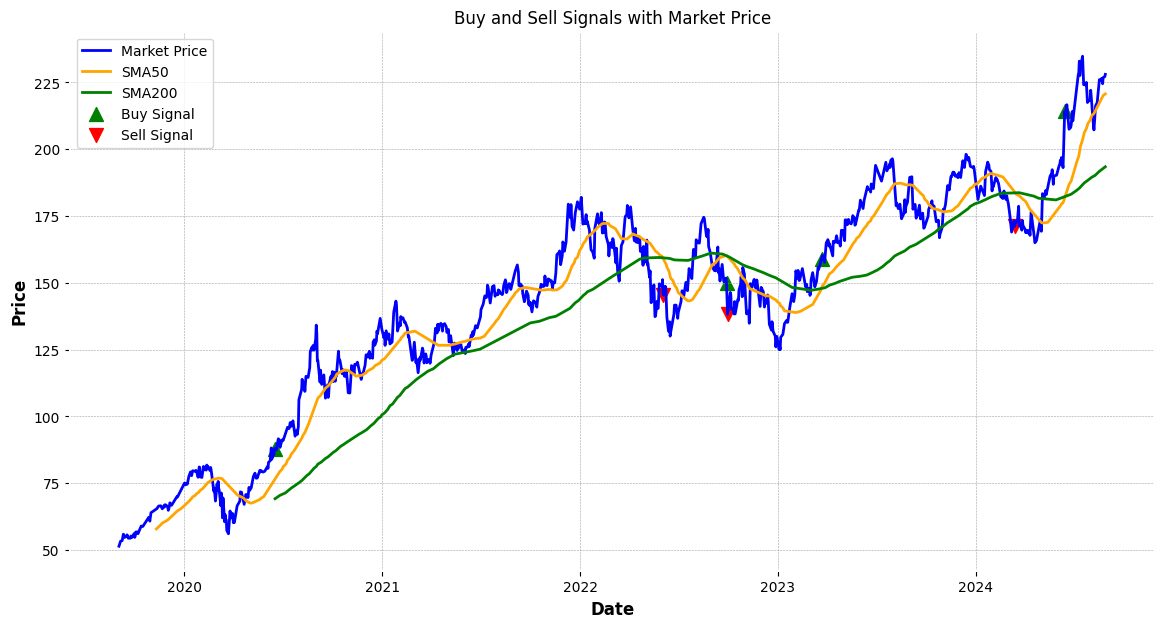

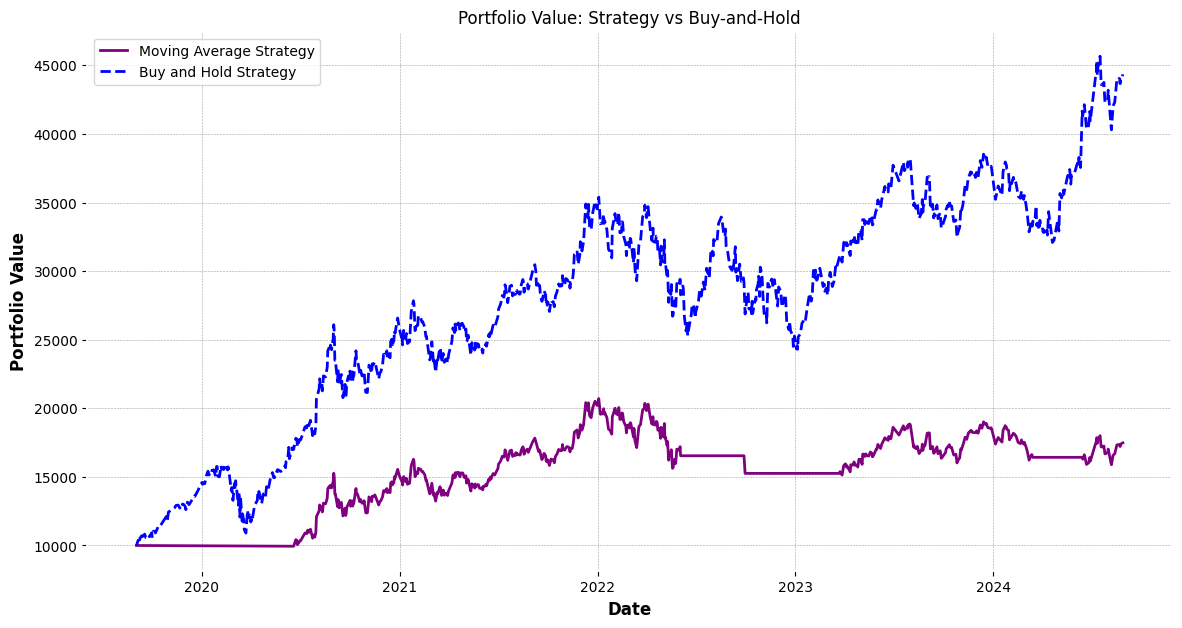

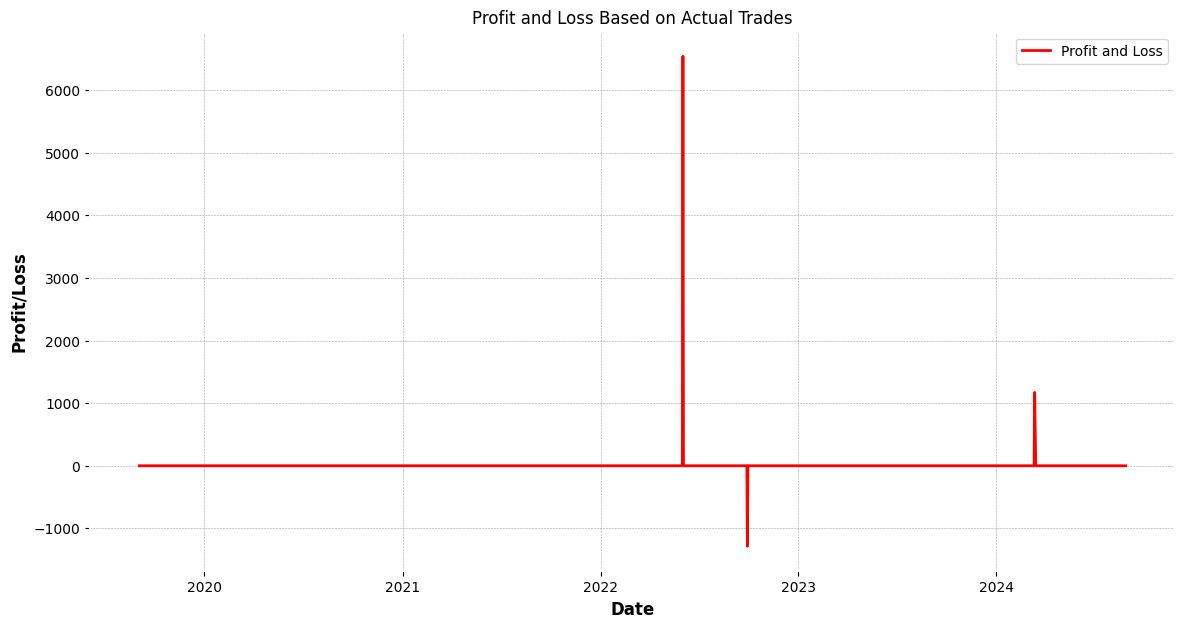

In [21]:
import pandas as pd
import matplotlib.pyplot as plt
import mplfinance as mpf

# Define technical indicators (e.g., moving averages)
def moving_average(df, window):
    return df['Close'].rolling(window=window).mean()

# Trading strategy: Moving Average Crossover
def strategy(df):
    df['SMA50'] = moving_average(df, 50)
    df['SMA200'] = moving_average(df, 200)
    df['Signal'] = 0
    df.loc[df['SMA50'] > df['SMA200'], 'Signal'] = 1
    df['Position'] = df['Signal'].diff()
    return df

# Backtesting with proper P&L calculation
def backtest(df, initial_balance=10000):
    df = strategy(df)
    balance = initial_balance
    position = 0  # Number of shares held
    portfolio_value = [initial_balance]  # Start with the initial balance
    pnl = []  # Track profit and loss
    buy_signals = []
    sell_signals = []
    last_buy_price = 0  # Track the price of the last buy

    for i in range(1, len(df)):
        if df['Position'].iloc[i] == 1:  # Buy signal
            buy_signals.append(df.index[i])
            position = balance / df['Close'].iloc[i]
            last_buy_price = df['Close'].iloc[i]
            balance = 0
            pnl.append(0)  # No P&L until we sell

        elif df['Position'].iloc[i] == -1 and position > 0:  # Sell signal
            sell_signals.append(df.index[i])
            sell_price = df['Close'].iloc[i]
            balance = position * sell_price
            trade_pnl = position * (sell_price - last_buy_price)
            pnl.append(trade_pnl)  # P&L for the trade
            position = 0
        else:
            pnl.append(0)  # No change in P&L if no trade happens
        
        current_value = balance + position * df['Close'].iloc[i]
        portfolio_value.append(current_value)

    final_balance = balance + position * df['Close'].iloc[-1] if len(df) > 0 else initial_balance
    
    # Ensure pnl list has the same length as df.index
    while len(pnl) < len(df):
        pnl.append(pnl[-1])

    return final_balance - initial_balance, buy_signals, sell_signals, portfolio_value, pnl

# Buy-and-Hold Strategy
def buy_and_hold(df, initial_balance=10000):
    initial_price = df['Close'].iloc[0]
    position = initial_balance / initial_price
    portfolio_value = df['Close'] * position
    return portfolio_value.tolist()

# Plotting functions
def plot_signals(df, buy_signals, sell_signals):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, df['Close'], label='Market Price', color='blue')
    plt.plot(df.index, df['SMA50'], label='SMA50', color='orange')
    plt.plot(df.index, df['SMA200'], label='SMA200', color='green')
    plt.scatter(buy_signals, df.loc[buy_signals]['Close'], marker='^', color='green', label='Buy Signal', s=100)
    plt.scatter(sell_signals, df.loc[sell_signals]['Close'], marker='v', color='red', label='Sell Signal', s=100)
    plt.title('Buy and Sell Signals with Market Price')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

def plot_portfolio_comparison(df, portfolio_value, buy_and_hold_value):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, portfolio_value, label='Moving Average Strategy', color='purple')
    plt.plot(df.index, buy_and_hold_value, label='Buy and Hold Strategy', color='blue', linestyle='--')
    plt.title('Portfolio Value: Strategy vs Buy-and-Hold')
    plt.xlabel('Date')
    plt.ylabel('Portfolio Value')
    plt.legend()
    plt.show()

def plot_pnl(df, pnl):
    plt.figure(figsize=(14, 7))
    plt.plot(df.index, pnl, label='Profit and Loss', color='red')
    plt.title('Profit and Loss Based on Actual Trades')
    plt.xlabel('Date')
    plt.ylabel('Profit/Loss')
    plt.legend()
    plt.show()

# New function to plot candlestick chart with mplfinance
def plot_candlestick_with_signals(df, buy_signals, sell_signals):
    buy_signals_df = pd.DataFrame(index=buy_signals, data={'Close': df.loc[buy_signals]['Close']})
    sell_signals_df = pd.DataFrame(index=sell_signals, data={'Close': df.loc[sell_signals]['Close']})

    # Ensure that the index for buy/sell signals matches the original DataFrame
 #   addplots = [
 #       mpf.make_addplot(df['SMA50'], color='orange'),
 #       mpf.make_addplot(df['SMA200'], color='green'),
 #       mpf.make_addplot(buy_signals_df['Close'], type='scatter', markersize=100, marker='^', color='green', label='Buy Signal'),
 #       mpf.make_addplot(sell_signals_df['Close'], type='scatter', markersize=100, marker='v', color='red', label='Sell Signal')
 #   ]
#
    mpf.plot(df, type='candle', style='charles', addplot=addplots, title='Candlestick Chart with Buy/Sell Signals', volume=True)

# Load the historical data from the CSV file
df = pd.read_csv('AAPL_5year.csv', parse_dates=['Date'], index_col='Date')

# Perform backtest and get buy/sell signals, portfolio value, and P&L
backtest_result, buy_signals, sell_signals, portfolio_value, pnl = backtest(df)
print(f"Backtest Result: {backtest_result:.2f}")

# Calculate portfolio value for the buy-and-hold strategy
buy_and_hold_value = buy_and_hold(df)

# Plot the signals
plot_signals(df, buy_signals, sell_signals)
    
# Plot portfolio value comparison
plot_portfolio_comparison(df, portfolio_value, buy_and_hold_value)
    
# Plot profit and loss over time
plot_pnl(df, pnl)

# Plot candlestick chart with buy/sell signals using mplfinance
#plot_candlestick_with_signals(df, buy_signals, sell_signals)
